# Einsendeaufgabe 2: Springende Bälle und Pendel (100 Punkte)

## Springende Bälle (60 Punkte)
In dieser Übung wollen wir einen NumPy Code entwickeln, den wir in der nächsten Übung optimieren. 

Wir wollen Bälle simulieren, die in einer Box herumspringen. Die Box sei von $x=[0,xmax]$ und $y=[0,ymax]$ definiert. Jede Kugel hat eine Koordinate $c=[x,y]$ und eine Geschwindigkeit $v=[v_x,v_y]$. In jedem Zeitschritt $\Delta t$ (dt) legt die Kugel eine gewisse Strecke zurück.

Es gilt nach den Regeln der Physik

$c[t+\Delta t]=c[t]+\Delta t*v(t)$. 

 
Zusätzlich wirkt in y-Richtung die Schwerkraft, welche die Geschwindigkeit verändert:
 
$v[t+\Delta t]=v[t]+\Delta t*g$. 


Wenn ein Ball an die Wand stößt, (also z.B. $c_0<=0$ oder $c_0>=xmax$ wird er reflektiert, das heißt in erster Näherung $v_0 = -1 * v_0$ für die Geschwindigkeit in dieser Richtung). Damit der Ball in diesem Fall nicht außerhalb der Box landet, müssen Sie berechnen, wie der Ball nun fliegt.

Der Ball stoppt nicht an der Wand, wenn er dort ankommt, sondern  fliegt noch ein Stück in die reflektierte Richtung. Um dies zu beachten, sollten wir die Rechnung noch etwas anpassen. 

Als Beispiel nehmen wir an, dass der Ball über $x=0$ hinaus fliegt.  Wenn wir also $c$ ausrechnen, gilt:  $c_x = c_x + v_x*\Delta t < 0 $.

Damit können wir ausrechnen, wie lange ($\Delta t_2$) unser Ball in die reflektierte Richtung geflogen ist: 

$abs(c_x)=\Delta t_2 * v_x$

also gilt:   
 
$\Delta t_2= \frac{abs(c_x)}{v_x}$. 

Für diese Zeit fliegt der Ball in die andere Richtung. Es gilt also 

$c_x = \Delta t_2 * (-v_x) = abs(c_x)$

<!-- BEGIN QUESTION -->

**Aufgabe:** Implementieren Sie die Funktion `timestep`, welche *einen* Zeitschritt für *einen Ball* simuliert. 

**Hinweis**:
- Die Entscheidungen, die Sie hier treffen, haben großen Einfluss auf die Performance. Es ist sehr wichtig, geeignete Kontroll- und Datenstrukturen zu wählen, um Overhead durch zu viele Objekte oder unnötige Kopien zu vermeiden.
- Wir haben hier eine schrittweise Simulation, dabei ist die Größe der Zeitschritte entscheidend, d.h. der Ball sollte in einem Zeitschritt nicht zu viel Strecke zurück gelegt haben. Daher sollte gelten: $\Delta_t \ll v$. Außerdem soll der Ball sich auch etwas bewegen können, daher muss $xmax,ymax \gg v$ sein.

_Points:_ 5

GIF wurde gespeichert: ball_simulation.gif


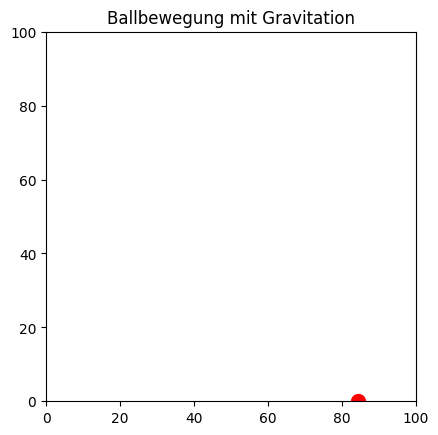

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# ------------------------------
# PHYSIKALISCHE PARAMETER
# ------------------------------

# Zeitintervall (in Sekunden)
dt = 0.1

# Gravitationsvektor (Beschleunigung in y-Richtung)
g = np.array([0, -9.81])

# Begrenzung des Simulationsraums
xmax = 100 
ymax = 100

# Anzahl an Simulationsschritten
steps = 1000

# Dämpfungsfaktor bei Kollisionen (Energieverlust)
damping_factor = 0.9

# Flag zur Aktivierung der Visualisierung (Trennung der Simulation und Visualisierung)
visualize = True

# ------------------------------
# SIMULATIONSFUNKTIONEN
# ------------------------------

def timestep(c, v, dt, g, xmax, ymax, damping):
    """
    Berechnet einen Zeitschritt für den Ball unter Einfluss von Gravitation,
    inklusive Kollisionserkennung mit Wänden und Energieverlust.

    Parameter:
    - c: aktuelle Position 
    - v: aktuelle Geschwindigkeit
    - dt: Zeitintervall
    - g: Gravitationsvektor
    - xmax, ymax: Begrenzung des Simulationsraums
    - damping: Dämpfungsfaktor bei Kollisionen

    Rückgabewerte:
    - Neue Positionen und Geschwindigkeiten nach einem Zeitschritt
    """
    # Bewegungsgleichung unter Berücksichtigung der Gravitation
    v = v + dt * g
    c_new = c + dt * v

    # Kollision mit linken/rechten Wänden
    if c_new[0] < 0:  # Wenn der Ball die linke Wand trifft
        dt2 = abs(c_new[0]) / abs(v[0])
        v[0] *= -1 * damping
        c_new[0] = dt2 * v[0]
    elif c_new[0] > xmax:  # Wenn der Ball die rechte Wand trifft
        dt2 = (c_new[0] - xmax) / abs(v[0])
        v[0] *= -1 * damping
        c_new[0] = xmax - dt2 * v[0]

    # Kollision mit oberer/unterer Wand
    if c_new[1] < 0:  # Wenn der Ball den Boden trifft
        dt2 = abs(c_new[1]) / abs(v[1])
        v[1] *= -1 * damping
        c_new[1] = dt2 * v[1]
    elif c_new[1] > ymax:  # Wenn der Ball die obere Wand trifft
        dt2 = (c_new[1] - ymax) / abs(v[1])
        v[1] *= -1 * damping
        c_new[1] = ymax - dt2 * v[1]

    return c_new, v


# Berechne Positionen und Geschwindigkeiten für die Anzahl der Schritte
def simulate_ball (steps, dt, g, xmax, ymax, damping_factor, vis):
    """
    Führt die Simulation durch und berechnet Bewegungen über mehrere Schritte.

    Optional können die Positionen für eine spätere Animation gespeichert werden.

    Parameter:
    - steps: Anzahl der Simulationsschritte
    - dt: Zeitintervall
    - g: Gravitationsvektor
    - xmax, ymax: Begrenzungen des Raumes
    - damping_factor: Energieverlust bei Kollision
    - vis: Flag zur Visualisierung (True = speichere Positionen)

    Rückgabewerte:
    - Liste aller Positionen (falls vis=True), sonst nur Statusmeldung
    """
    
    # Startzustand
    pos = np.array([20.0, 80.0])  # Startposition des Balls (x, y)
    vel = np.array([10.0, 10.0])   # Startgeschwindigkeit des Balls (vx, vy)
    
    # Speicherung der Positionen für Visualisierung
    if vis == True:
        positions = [pos.copy()]
        #velocities = [vel.copy()]
    
    #  Schrittweise Simulation  
    for i in range(steps):
        pos, vel = timestep(pos, vel, dt, g, xmax, ymax, damping_factor)
        if vis == True:
            positions.append(pos.copy())  # Füge die neue Position hinzu
            #velocities.append(new_vel.copy())  # Füge die neue Geschwindigkeit hinzu
            
    if vis == True:
        return positions#, velocities
    else:
        return


# ------------------------------
# VISUALISIERUNG
# ------------------------------

def animate_positions(positions, xmax, ymax, filename="ball_simulation.gif"):
    """
    Erstellt eine Animation der gespeicherten Positionen und speichert sie als GIF.

    Parameter:
    - positions: Liste der Positionen des Balls pro Frame
    - xmax, ymax: Grenzen des Simulationsraums
    - filename: Dateiname für das exportierte GIF
    """
    # Plot setup
    fig, ax = plt.subplots()
    ball, = ax.plot([], [], 'ro', markersize=10)  # Erstelle den Ball als roten Punkt
    ax.set_xlim(0, xmax)  # x-Achsen-Bereich
    ax.set_ylim(0, ymax)  # y-Achsen-Bereich
    ax.set_aspect('equal')  # Gleiche Skalierung auf beiden Achsen
    ax.set_title("Ballbewegung mit Gravitation")  # Titel des Plots

    # Init-Funktion für das Plot
    def init():
        ball.set_data([], [])  # Setze den Ball an den Anfang (leer)
        return ball,

    # Update-Funktion für das Plot
    def update(frame):
        pos = positions[frame]  # Hole die Position des Balls für das aktuelle Frame
        ball.set_data([pos[0]], [pos[1]])  # Setze die Position des Balls im Plot
        return ball,

    # Animation erstellen
    ani = FuncAnimation(fig, update, frames=len(positions), init_func=init, blit=True, interval=50)

    # Als GIF speichern
    ani.save(filename, writer=PillowWriter(fps=20))
    print(f"GIF wurde gespeichert: {filename}")
    
# ------------------------------
# HAUPTFUNKTION
# ------------------------------

if visualize == True:
    # Führe Simulation mit Visualisierung durch und animiere das Ergebnis
    all_positions = simulate_ball(
        steps, dt, g, xmax, ymax, damping_factor, visualize
    )
    animate_positions(all_positions, xmax, ymax)
else:
    # Nur reine Simulation ohne Animation
    simulate_ball(
        steps, dt, g, xmax, ymax, damping_factor, visualize
    )
    print("Simulation (ohne Visualisierung) war erfolgreich")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Animieren Sie die Bewegung des Balls. Der Ball sollte mit der Zeit an Höhe verlieren (durch die Schwerkraft).

Hinweis: Simulation und Visualisierung müssen getrennt sein (für die nächste Aufgabe).

_Points:_ 5

In [2]:
import numpy as np

# Anfangsbedingungen (Vorschlag)
dt = 0.1
g = np.array([0, -9.81], dtype=np.float64)
xmax = 100
ymax = 100
steps = 100
# Startposition: x=500, y=500.
# ...
# Startgeschwindigkeit: v_x=20, v_y=0
# ...


...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Ein Ball ist jedoch langweilig, daher wollen wir als nächstes mehrere Bälle simulieren.  
Schreiben Sie eine neue Funktion, `timestep_balls`, welche einen Array mit Koordinaten (shape=(N,2)) und einen Array mit Geschwindigkeiten (shape=(N,2)) übergeben bekommt und für alle Bälle einen Zeitschritt berechnet. 

Achten Sie darauf, dass der Code performant ist und verwenden Sie NumPys interne Vektorisierung mit der Slicing Syntax.  Für den Augenblick ignorieren wir, dass die Bälle zusammenstoßen können. 

Hinweis: 
- Das Array `c` sollte diese Form haben: 

$c = \left[\begin{array}{rr}                                 
x_0 & y_0 \\ 
x_1 & y_1 \\ 
x_2 & y_2 \\ 
\dots \\ 
x_{n-1} & y_{n-1} \\ 
\end{array}\right]$ 

- Das Array `v` sollte diese Form haben: 

$v = \left[\begin{array}{rr}                                 
v^x_0 & v^y_0 \\ 
v^x_1 & v^y_1 \\ 
v^x_2 & v^y_2 \\ 
\dots\\ 
v^x_{n-1} & v^y_{n-1} \\ 
\end{array}\right]$ 

_Points:_ 10

In [3]:
def timestep_balls(c, v, dt, g, xmax, ymax):
    """
    Simulate a timestep for multiple balls.

    Parameters:
        c: ...
        v: ...
        dt: The duration of a single timestep.
        g: Gravitation
        xmax: Box limit in x direction
        ymax: Box limit in y direction
    """
    ...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Animieren Sie die Bewegung der Bälle.

Tipp: Trennen Sie Simulation und Visualisierung.

_Points:_ 10

In [4]:
import numpy as np

# Anfangsbedingungen (Vorschlag)
dt = 1
g = np.array([0, -9.81], dtype=np.float64)
xmax = 1000
ymax = 1000
steps = 250

# Anzahl Bälle
N = 10
rng = np.random.default_rng(seed=123)
# Startpositionen
c = xmax * rng.random((N, 2))
# Startgeschwindigkeiten
v = 10 * rng.random((N, 2))

...

Ellipsis

<!-- END QUESTION -->

## Leistungsanalyse ohne Visualisierung

<!-- BEGIN QUESTION -->

**Aufgabe:** Analysieren Sie zunächst die Leistung der Ball-Simulation ohne Visualisierung mit Scalene!
Simulieren Sie dazu 100 Bälle für 100 Zeitschritte und verwenden Sie eine Abtastfrequenz von $0.0001$.

*Hinweis:* Wir haben die Initialisierungsfunktion aus dem Profiling entfernt, da sie ansonsten zu dominant wäre.
Wenn Sie den Code richtig optimiert haben, sollte die Funktion zu über 95% im nativen Modus ausgeführt werden.

_Points:_ 15

In [5]:
%load_ext scalene

ModuleNotFoundError: No module named 'scalene'

In [ ]:
# Anfangsbedingungen (Vorschlag)
dt = 1
g = np.array([0, -9.81], dtype=np.float64)
xmax = 1000
ymax = 1000
steps = 1000

# Anzahl Bälle
N = 100
rng = np.random.default_rng(seed=123)
# Startpositionen
c = xmax * rng.random((N, 2))
# Startgeschwindigkeiten
v = 10 * rng.random((N, 2))

In [ ]:
%%scalene --cpu-sampling-rate 0.0001
...

<!-- END QUESTION -->

## Leistungsanalyse mit Visualisierung

<!-- BEGIN QUESTION -->

**Aufgabe:** Die Visualisierung erfordert, dass die Ergebnisse nach jeder Iteration gespeichert werden. Analysieren Sie mit Hilfe von Scalene, wie sich das auf die Performance auswirkt. 

- Wie viel der gesamten Laufzeit kostet dieses Kopieren der Ergebnisse?
- Wie lässt sich das verbessern?

_Points:_ 15

_Type your answer here, replacing this text._

In [ ]:
%%scalene --cpu-sampling-rate 0.001
...

<!-- END QUESTION -->

## Einfaches Pendel (40 Punkte)

Die Bewegung eines einfachen Pendels kann man mit der Gleichung

$\theta^{''}(t) +\frac{b}{m}\theta^{'}(t) +\frac{g}{L}\theta(t) = 0$ 

beschrieben, wobei gilt:

- $\theta$ : Ausrichtungs-Wingel
- $b$ : Dämpfung (z.b. durch Luftwiderstand)
- $m$ : Masse des Pendel-Körpers
- $g$ : Erdbeschleunigung 
- $L$ : Länge des Pendels
- $\theta^{'}$: Winkel-Geschwindigkeit
- $\theta^{''}$: Winkel-Beschleunigung

Die Ausrichtungen x, y werden mit Hilfe von $\theta$ berechnet:

$ x = L * sin(\theta) $

$ y = -L * cos(\theta) $

Der Ursprung des Pendels liegt bei (0,0).

Das Pendel sei Anfangs zu $\frac{\pi}{3}$ ausgerichtet und hat eine Gechwindigkeit von 0. 

<!-- BEGIN QUESTION -->

**Aufgabe:** Berechnen Sie die Bewegung des Pendels für $t=[0,...,15]$ für 20000 Zeitschritte. Verwenden Sie die SciPy funktion `integrate.solve_ivp`.

_Points:_ 10

# Lösung der Aufgabe: Einfaches Pendel mit Dämpfung

In dieser Aufgabe wird die Bewegung eines **gedämpften einfachen Pendels** simuliert. Das Pendel wird durch die folgende **Differentialgleichung zweiter Ordnung** beschrieben:

$\theta''(t) + \frac{b}{m} \theta'(t) + \frac{g}{L} \theta(t) = 0$

bzw.

$\alpha(t) + \frac{b}{m} \omega(t) + \frac{g}{L} \theta(t) = 0$

Dabei bedeuten:

- $\theta(t)$: Winkel des Pendels zur Vertikalen in Radiant  
- $\omega(t) = \theta'(t)$: Winkelgeschwindigkeit  
- $\alpha(t) = \theta''(t)$: Winkelbeschleunigung  
- $b$: Dämpfungskoeffizient (z. B. durch Luftwiderstand)  
- $m$: Masse des Pendelkörpers  
- $g$: Erdbeschleunigung  
- $L$: Länge des Pendels  

---

### Ziel der Aufgabe

Wir möchten die Bewegung des Pendels im Zeitbereich $t = 0$ bis $t = 15$ Sekunden simulieren – und zwar mit **20.000 Zeitschritten** für eine möglichst feine zeitliche Auflösung. Dafür verwenden wir die numerische Methode `solve_ivp` aus `scipy.integrate`, welche ein **System von Differentialgleichungen erster Ordnung** löst.

---

### Umformulierung in ein System erster Ordnung

Da `solve_ivp` nur Gleichungen erster Ordnung lösen kann, muss die Gleichung zweiter Ordnung umgeschrieben werden. Dazu setzen wir:

- $y_0 = \theta(t)$: Winkel  
- $y_1 = \theta'(t)$: Winkelgeschwindigkeit  

Damit ergibt sich das folgende System:

$y_0' = y_1$  
$y_1' = -\frac{b}{m} y_1 - \frac{g}{L} y_0$

Dieses System beschreibt die zeitliche Entwicklung des Pendels vollständig und ist bereit zur numerischen Lösung.

---

### Erläuterung des Codes

1. **Parameterdefinition:** Die physikalischen Konstanten wie Pendellänge $L$, Masse $m$, Dämpfungskoeffizient $b$ und Erdbeschleunigung $g$ werden gesetzt.

2. **Zeitvektor:** Mit `np.linspace(0, 15, 20000)` wird ein Array von Zeitpunkten erzeugt, an denen das System berechnet wird.

3. **Modellierung des Systems:** Die Funktion `pendel(t, y)` bildet das oben beschriebene Gleichungssystem ab. Sie gibt die Ableitungen von Winkel und Winkelgeschwindigkeit zurück.

4. **Numerische Lösung:** `solve_ivp` berechnet aus den Anfangswerten (Startwinkel $\theta = \frac{\pi}{3}$, Anfangsgeschwindigkeit $= 0$) die Entwicklung des Systems über die Zeit mithilfe eines Runge-Kutta-Verfahrens (`RK45`).

5. **Berechnung der Position:** Aus dem berechneten Winkel $\theta(t)$ werden mit Hilfe der bekannten Formeln für Kreisbewegung die kartesischen Koordinaten des Pendelkörpers berechnet:

$x(t) = L \cdot \sin(\theta(t))$  
$y(t) = -L \cdot \cos(\theta(t))$

6. **Visualisierung:** Die Pendelbewegung wird in einem x-y-Diagramm dargestellt, wodurch die oszillierende und gedämpfte Bewegung deutlich sichtbar wird.

---

Dieser strukturierte Ansatz erlaubt eine anschauliche und realitätsnahe Simulation eines gedämpften Pendels – unter Berücksichtigung von Reibungsverlusten, wie sie z. B. durch Luftwiderstand entstehen.

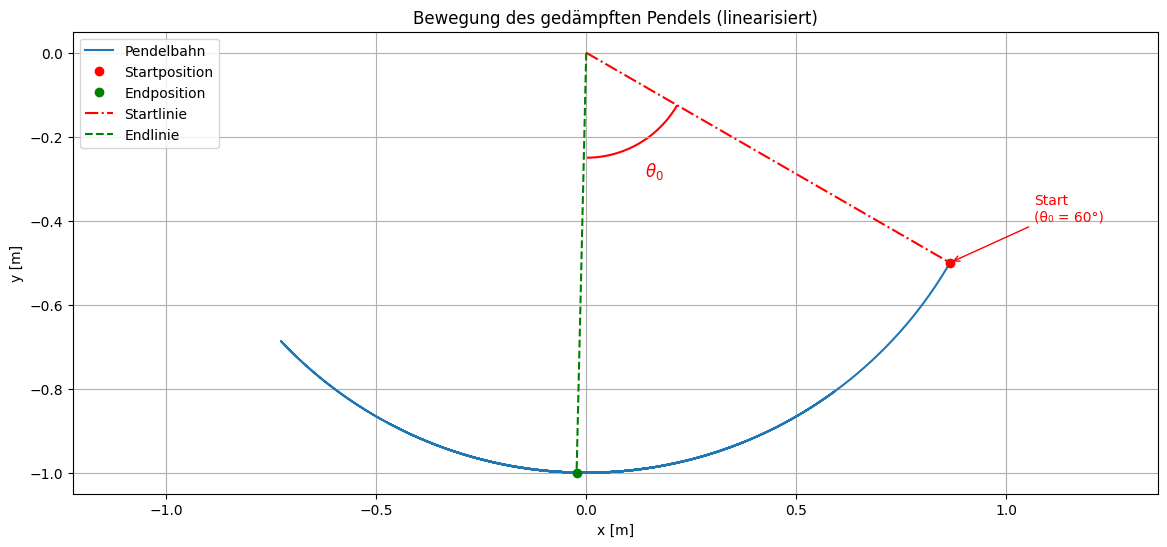

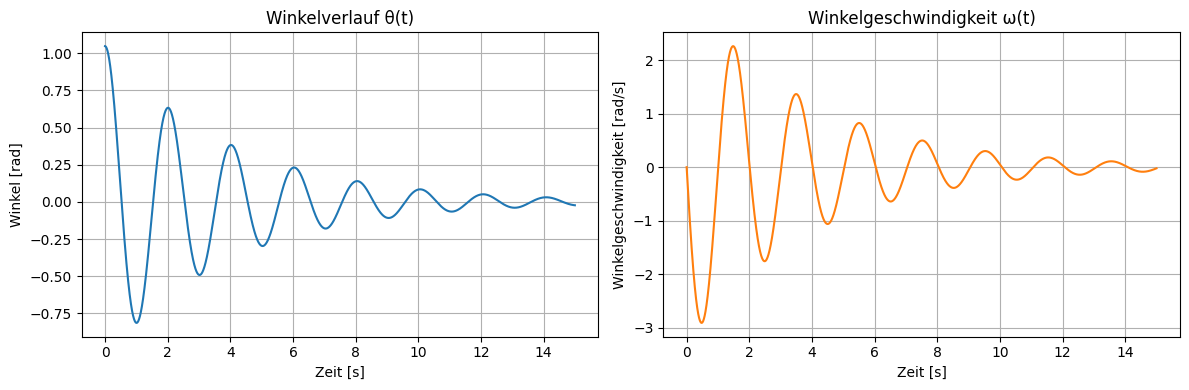

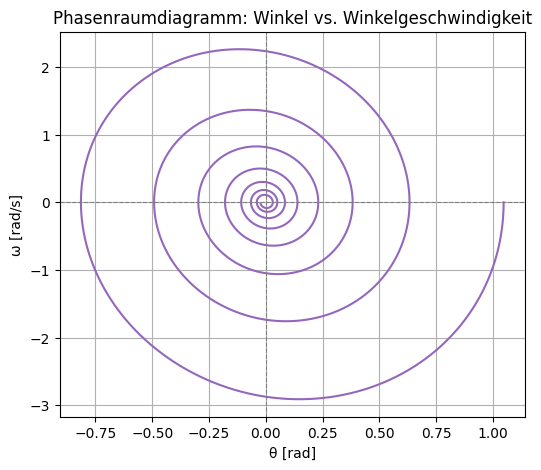

In [1]:
import numpy as np                      # Numpy wird für die numerischen Berechnungen benötigt (z.B. sin, cos, linspace)
from scipy.integrate import solve_ivp   # SciPy wird genutzt, um das Anfangswertproblem zu lösen
import matplotlib.pyplot as plt         # Matplotlib wird für die grafische Darstellung der Ergebnisse verwendet
import matplotlib.patches as patches    # Für den Winkelbogen (Zeichnung im Diagramm am Ende)

# Parameter
L = 1                   # Pendellänge in Metern
m = 1                   # Masse des Pendels in kg
b = 0.5                 # Dämpfung in Ns·m/rad (vereinfacht als lineare Dämpfung für Rotationssystem behandelt)
g = 9.81                # Erdbeschleunigung in m/s²
steps = 20000           # Anzahl der Zeitschritte für die Simulation (hohe Auflösung)
t_max = 15              # Maximale Simulationszeit in Sekunden
theta0 = np.pi / 3      # Anfangswinkel des Pendels (60° in Radiant)
omega0 = 0              # Anfangsgeschwindigkeit (ω0 = θ'(t=0) = (dθ/dt|t=0) = 0); Pendel startet aus dem Stillstand ohne Anfangsgeschwindigkeit (nur Anfangsauslenkung theta0)

# Zeitpunkte für die Auswertung
# t_eval enthält 20.000 gleichmäßig verteilte Zeitpunkte zwischen 0 und t_max
# Diese Zeitpunkte werden später an die Funktion solve_ivp übergeben, damit die Lösung
# des Differentialgleichungssystems an diesen Zeitpunkten berechnet wird.
t_eval = np.linspace(0, t_max, steps) 

# Definition des Differentialgleichungssystems in erster Ordnung (linearisierte Pendelgleichung)
# Die Pendelbewegung wird als System von zwei Gleichungen erster Ordnung formuliert:
# y[0] = θ (Winkelposition) und y[1] = ω (Winkelgeschwindigkeit)
# Gesucht: dθ/dt = ω und dω/dt = -(b/m) * ω - (g/L) * θ
def pendel(t, y):
    """
    Diese Funktion beschreibt die Pendelbewegung als System von zwei Differentialgleichungen erster Ordnung:
    1. dθ/dt = ω (Winkelgeschwindigkeit)
    2. dω/dt = -(b/m) * ω - (g/L) * θ (gedämpfte Schwingung, linearisierte Pendelgleichung)

    Inputs:
    - t (float): Der aktuelle Zeitpunkt. 
        - Dieser Wert wird vom Solver `solve_ivp` übergeben. Obwohl der Zeitpunkt nicht direkt in den Berechnungen verwendet wird,
        ist er erforderlich, damit der Solver das Problem korrekt lösen kann, da `solve_ivp` den aktuellen Zeitpunkt benötigt,
        um die numerische Lösung über die Zeit zu berechnen.

    - y (List[float]): Ein Vektor mit zwei Werten:
        - y[0] = θ (Winkel des Pendels in Radiant)
        - y[1] = ω (Winkelgeschwindigkeit in Rad/s)
        - Dieser Vektor enthält die aktuellen Werte der Variablen des Systems und wird ebenfalls vom Solver `solve_ivp` bei jedem Schritt
        an die Funktion übergeben.

    Outputs:
    - List[float]: Ein Vektor mit den Ableitungen von θ und ω:
        - [dθ/dt, dω/dt] = [ω, -(b/m) * ω - (g/L) * θ]
        - Der erste Wert ist die Winkelgeschwindigkeit ω, also die Ableitung von θ nach der Zeit.
        - Der zweite Wert ist die Winkelbeschleunigung dω/dt, die durch die linearisierte Pendelgleichung berechnet wird.
        - Diese Ausgaben werden vom Solver `solve_ivp` verwendet, um die nächste Zeitstufe der Lösung zu berechnen.
    """

    theta, omega = y # Entpacken des Zustandsvektors y = [θ, θ'] = [θ, ω]

    # Die zweite Ableitung von θ (d²θ/dt² = dω/dt = α. Winkelbeschleunigung) basiert auf der linearen Bewegungsgleichung
    # α = dω/dt = -(b/m) * ω - (g/L) * θ (gedämpfte harmonische Schwingung)
    alpha = -(b / m) * omega - (g / L) * theta  # dω/dt = - (b/m) * ω - (g/L) * θ

    # Rückgabe der beiden Ableitungen als Liste
    return [omega, alpha] # [dθ/dt, dω/dt] = [ω, α]

# Numerische Lösung des Differentialgleichungssystems mit solve_ivp (Runge-Kutta-Verfahren)
# solve_ivp löst das Anfangswertproblem für gewöhnliche Differentialgleichungen
# Der Rückgabewert 'sol' enthält die numerische Lösung der Gleichungen über den angegebenen Zeitraum
# Anfangswerte: θ(0) = theta0, ω(0) = omega0
sol = solve_ivp(pendel,             # Funktion, die das Differentialgleichungssystem beschreibt
                [0, t_max],         # Zeitintervall [Startzeit, Endzeit] für die Berechnung
                [theta0, omega0],   # Anfangszustand: [θ(0), ω(0)] = [theta0, omega0] = [np.pi / 3, 0] (Start aus der Ruheposition)
                t_eval=t_eval,      # Zeitpunkte, an denen die Lösung berechnet werden soll
                method='RK45')      # Das Runge-Kutta-Verfahren (4. & 5. Ordnung) zur numerischen Lösung

# Berechnung der Positionen des Pendels in der x-y-Ebene basierend auf den Winkeln θ(t)
# Um den Pendelkörper im Raum zu beschreiben, benötigen wir die kartesischen Koordinaten
# mit den Beziehungen: x = L * sin(θ) und y = -L * cos(θ), wobei das Pendel am Ursprung (0, 0) befestigt ist.
theta = sol.y[0]        # θ(t): Die Winkelpositionen des Pendels zu den jeweiligen Zeitpunkten
x = L * np.sin(theta)   # Berechnung der x-Position: x(t) = L * sin(θ(t)). Dies beschreibt, wie weit der Pendelkörper horizontal (also in Richtung der x-Achse) von der Aufhängung entfernt ist, abhängig vom Winkel θ.
y = -L * np.cos(theta)  # Berechnung der y-Position: y(t) = -L * cos(θ(t)). Dies beschreibt, wie weit der Pendelkörper in vertikaler Richtung (also in Richtung der y-Achse) von der Aufhängung entfernt ist. Das negative Vorzeichen sorgt dafür, dass sich der Pendelkörper nach unten bewegt, da die y-Achse nach oben zeigt.


# ================================================================
# VISUALISIERUNG DER PENDLELBEWEGUNG UND ZEITVERLÄUFE
# ================================================================

# -----------------------------
# Plot 1: Pendelbahn in der x-y-Ebene
# -----------------------------
# Dieser Plot zeigt die reale Bahn des Pendels in der 2D-Ebene.

plt.figure(figsize=(14, 6))  # Großes Format für bessere Darstellung
plt.plot(x, y, label='Pendelbahn')  # Bahnkurve des Pendels
plt.xlabel('x [m]')  # x-Achse: horizontale Auslenkung
plt.ylabel('y [m]')  # y-Achse: vertikale Position
plt.title('Bewegung des gedämpften Pendels (linearisiert)')  # Titel
plt.axis('equal')  # Gleiche Skalierung der Achsen (Kreisbahn korrekt dargestellt)
plt.grid(True)     # Gitternetz für bessere Lesbarkeit

origin = (0, 0)  # Koordinatenursprung = Aufhängepunkt

# --- Startposition markieren ---
plt.plot(x[0], y[0], 'ro', label='Startposition')  # Roter Punkt am Anfang
plt.annotate(f'Start\n(θ₀ = {np.degrees(theta0):.0f}°)',  # Winkel in Grad
             xy=(x[0], y[0]), xytext=(x[0] + 0.2, y[0] + 0.1),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red')

# --- Endposition markieren ---
plt.plot(x[-1], y[-1], 'go', label='Endposition')  # Grüner Punkt am Ende

# --- Linien vom Ursprung zu Start- und Endposition ---
plt.plot([origin[0], x[0]], [origin[1], y[0]], 'r-.', label='Startlinie')  # Rot gestrichelt
plt.plot([origin[0], x[-1]], [origin[1], y[-1]], 'g--', label='Endlinie')  # Grün gestrichelt

# --- Winkelbogen θ₀ einzeichnen ---
theta0_deg = np.degrees(theta0)  # Umrechnung in Grad für Darstellung
arc_radius = 0.5  # Radius des Winkelbogens
arc = patches.Arc(origin, arc_radius, arc_radius, angle=0,
                  theta1=-90, theta2=-90 + theta0_deg,
                  color='red', linewidth=1.5)
plt.gca().add_patch(arc)  # Bogen ins aktuelle Achsenobjekt einfügen

# --- Beschriftung θ₀ am Winkelbogen platzieren ---
theta_mid_rad = np.radians(-90 + theta0_deg / 2)  # Mittelwertwinkel für Textposition
label_radius = arc_radius * 0.65  # Etwas näher am Ursprung als der Bogen selbst
x_label = label_radius * np.cos(theta_mid_rad)
y_label = label_radius * np.sin(theta_mid_rad)
plt.text(x_label, y_label, r'$\theta_0$', fontsize=12, color='red',
         ha='center', va='center')  # Mathematischer Winkel in LaTeX

plt.legend(loc='upper left')  # Legende platzieren
plt.show()  # Plot anzeigen

# -----------------------------
# Plot 2: Zeitverlauf von Winkel θ(t) und Winkelgeschwindigkeit ω(t)
# -----------------------------
# Darstellung der Zustandsgrößen über die Zeit in zwei Teilplots

plt.figure(figsize=(12, 4))  # Querformat für nebeneinander liegende Plots

# --- Subplot links: θ(t) ---
plt.subplot(1, 2, 1)
plt.plot(sol.t, sol.y[0], color='tab:blue')  # θ(t)
plt.title('Winkelverlauf θ(t)')
plt.xlabel('Zeit [s]')
plt.ylabel('Winkel [rad]')
plt.grid(True)

# --- Subplot rechts: ω(t) ---
plt.subplot(1, 2, 2)
plt.plot(sol.t, sol.y[1], color='tab:orange')  # ω(t)
plt.title('Winkelgeschwindigkeit ω(t)')
plt.xlabel('Zeit [s]')
plt.ylabel('Winkelgeschwindigkeit [rad/s]')
plt.grid(True)

plt.tight_layout()  # Optimiert Abstand zwischen den beiden Plots
plt.show()

# -----------------------------
# Plot 3: Phasenraumdarstellung θ vs. ω
# -----------------------------
# Dieser Plot zeigt den Zustand des Systems im Phasenraum
# (Winkel vs. Winkelgeschwindigkeit), was besonders für die
# Analyse des dynamischen Verhaltens nützlich ist.

plt.figure(figsize=(6, 5))
plt.plot(sol.y[0], sol.y[1], color='tab:purple')  # θ gegen ω
plt.xlabel('θ [rad]')
plt.ylabel('ω [rad/s]')
plt.title('Phasenraumdiagramm: Winkel vs. Winkelgeschwindigkeit')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Nulllinie ω = 0
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')  # Nulllinie θ = 0
plt.show()


<!-- END QUESTION -->

**Aufgabe:** Die Funktion ` scipy.integrate.solve_ivp` bietet verschiedene Methoden zur Lösung an [[1]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). Vergleichen Sie die Performance für die Methoden, die keine weiteren Eingaben erwarten (RK45, RK23 und DOP853). 

_Points:_ 3

In [ ]:
rk45_timeit = ...
rk23_timeit = ...
dop853_timeit = ...

<!-- BEGIN QUESTION -->

**Aufgabe:** Stellen Sie die x- und y-Position des Pendels über die Zeit in einem Diagramm dar. 
Stellen Sie in einem zweiten Diagramm den Winkel über die Zeit dar.

Hinweis:
- Verwenden Sie die Lösung für die `RK45` Methode. 
- Verwenden Sie Liniendiagramme.

_Points:_ 10

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Stellen Sie den Unterschied zwischen der 'RK45' Methode und der 'RK23' Methode dar. 

Erstellen Sie vier Liniendiagramme:
- x für beide Methoden über der Zeit
- y für beide Methoden über der Zeit
- Absoluter Unterschied von x zwischen beiden Methoden über der Zeit
- Absoluter Unterschied von y zwischen beiden Methoden über der Zeit

_Points:_ 10

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Animieren Sie das Pendel, sodass es für mindestens eine Periodendauer pendelt.

Hinweis:
- Animieren Sie nicht alle Zeitschritte, sondern z.B. nur jeden 100. Zeitschritt.
- Damit die Animation schneller erstellt wird, können Sie z.B. die zweite Hälfte der Daten verwerfen.
- Tipp für "hvplot": aus `import holoviews as hv` ist [hv.Path() hilfreich](https://holoviews.org/reference/elements/bokeh/Path.html)

_Points:_ 7

In [ ]:
...

<!-- END QUESTION -->

Führen Sie alle Zellen im Notebook aus und speichern Sie es.  
Danach können Sie mit der folgenden Zelle eine HTML-Datei erstellen.  
Eine mögliche `UserWarning` können Sie ignorieren.  
Bitte geben Sie das Notebook als `.ipynb` und `.html` Datei ab.

In [ ]:
#!jupyter nbconvert --to html EA2.ipynb